In [1]:
# default_exp data

# Import

In [2]:
#export
import copy
import random
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import nvidia.dali.ops as ops
import nvidia.dali.tfrecord as tfrec
import nvidia.dali.types as types
import pandas as pd
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
from IPython.core.debugger import set_trace
from joblib import Parallel, delayed
from nvidia.dali.pipeline import Pipeline
from nvidia.dali.plugin.pytorch import DALIGenericIterator
from PIL import Image
from tqdm.notebook import tqdm

# Config

In [3]:
dir_data = Path('data')
dir_content = dir_data/'content'

# Utility

In [4]:
#export
def torch2np(img): return img.permute(1,2,0).detach().cpu().numpy()

In [5]:
#export
def denorm(img): return (img*np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)

# Dali pipeline

In [6]:
#export
class ImgFolderPipeline(Pipeline):
    def __init__(self, dir_imgs, batch_size, num_workers, device_id=0):
        super().__init__(batch_size, num_workers, device_id)
        self.input = ops.FileReader(file_root=dir_imgs, 
                                    random_shuffle=True)
        
        self.decode = ops.ImageDecoder(device='mixed', 
                                       output_type=types.RGB)
        
        self.cmnp = ops.CropMirrorNormalize(device='gpu',
                                            output_dtype=types.FLOAT,
                                            output_layout=types.NCHW,
                                            image_type=types.RGB,
                                            mean=[124, 116, 104],
                                            std= [ 58,  57,  57])

    def define_graph(self):
        imgs, _ = self.input()   
        imgs = self.decode(imgs) # Images are decoded on gpu
        imgs = self.cmnp(imgs)   # This also converts from NHWC -> NCHW
        return (imgs)

In [7]:
#export
class TFRecordPipeline(Pipeline):
    def __init__(self, file_tfrecord, batch_size, num_workers, device_id=0):
        super().__init__(batch_size, num_workers, device_id)
        self.input = ops.TFRecordReader(path=file_tfrecord.as_posix(),
                                        index_path=(file_tfrecord.parent/(file_tfrecord.stem + '.idx')).as_posix(),
                                        features={'encoded': tfrec.FixedLenFeature((), tfrec.string, "")})
        
        self.decode = ops.ImageDecoder(device='mixed', 
                                       output_type=types.RGB)
        
        self.cmnp = ops.CropMirrorNormalize(device='gpu',
                                            output_dtype=types.FLOAT,
                                            output_layout=types.NCHW,
                                            image_type=types.RGB,
                                            mean=[124, 116, 104],
                                            std= [ 58,  57,  57])

    def define_graph(self):
        imgs = self.input(name="Reader")['encoded'] 
        imgs = self.decode(imgs) # Images are decoded on gpu
        imgs = self.cmnp(imgs)   # This also converts from NHWC -> NCHW
        return (imgs)

# Datasets

In [8]:
#export
class ImgCSVDataset(data.Dataset):
    def __init__(self, dir_imgs, file_csv, tfms=None):
        self.dir_imgs = dir_imgs
        self.tfms = tfms
        self.df = pd.read_csv(file_csv)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):    
        img = Image.open(self.dir_imgs/self.df.loc[idx, 'name']).convert('RGB')
                       
        if self.tfms is not None:
            img = self.tfms(img)
            
        return img, copy.deepcopy(img)

# Dataloader

In [9]:
#export
class SubsetSampler(data.Sampler):
    def __init__(self, data_source, num_samples=None):
        self.data_source = data_source
        self.num_samples = num_samples if num_samples is not None else len(data_source)
        
    def __iter__(self):
        n = len(self.data_source)
        return iter(torch.randperm(n)[:self.num_samples].tolist())

    def __len__(self):
        return self.num_samples

In [10]:
#export
class SubsetDataloader(data.DataLoader):
    def __init__(self, dataset, num_samples=None, **kwargs):
        super().__init__(dataset, sampler=SubsetSampler(dataset, num_samples), **kwargs)

In [11]:
#export
class DaliDataloader():
    def __init__(self, pipeline, num_samples):
        self.pipeline = pipeline
        self.num_samples = num_samples
        
        self.pipeline.build()
        
    def __iter__(self):
        self.di = DALIGenericIterator(self.pipeline, ['img'], self.num_samples)
        return self
        
    def __next__(self):
        img = next(self.di)[0]['img']    
        return img, copy.deepcopy(img)

# Test

### Image CSV dataset

In [12]:
def _get_img_csv_dataset(t, tfms=None):
    return ImgCSVDataset(dir_content/'formatted_256'/t/'imgs', dir_content/f'{t}.csv', tfms)

In [13]:
tfms = transforms.Compose([transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                std=[0.229, 0.224, 0.225])])

In [14]:
ds_trn = _get_img_csv_dataset('trn', tfms)

In [15]:
batch_size = 4
num_workers = 4
pin_memory = False
num_samples = 6

dl_trn = SubsetDataloader(ds_trn, 
                          batch_size=batch_size,
                          num_workers=num_workers,
                          pin_memory=pin_memory,
                          num_samples=num_samples)

In [16]:
%timeit next(iter(dl_trn))

55.8 ms ± 797 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


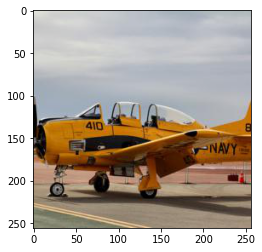

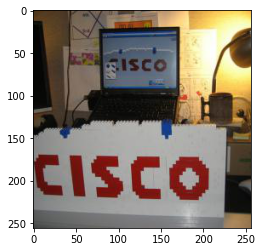

In [17]:
for idx, (X,y) in enumerate(dl_trn):
    plt.figure(idx)
    img = torch2np(X[0])
    plt.imshow(denorm(img))

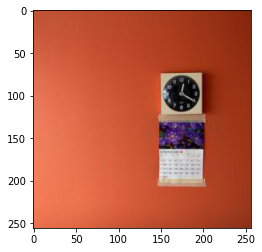

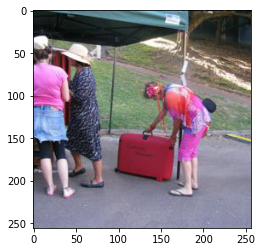

In [18]:
for idx, (X,y) in enumerate(dl_trn):
    plt.figure(idx)
    img = torch2np(X[0])
    plt.imshow(denorm(img))

### Dali Image Folder Dataloader

In [19]:
batch_size = 4
num_workers = 4
num_samples = 6

pipeline_trn = ImgFolderPipeline(dir_imgs=dir_content/'formatted_256'/'trn',
                                 batch_size=batch_size,
                                 num_workers=num_workers)
dl_trn = DaliDataloader(pipeline_trn, num_samples)

In [20]:
%timeit next(iter(dl_trn))

3.69 ms ± 1.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


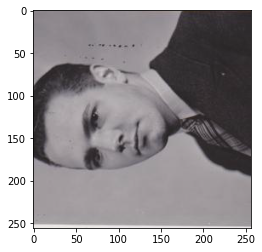

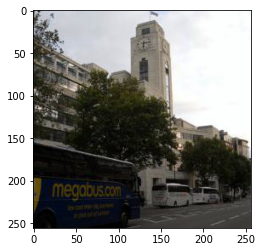

In [21]:
for idx, (X,y) in enumerate(dl_trn):
    plt.figure(idx)
    img = torch2np(X[0])
    plt.imshow(denorm(img))

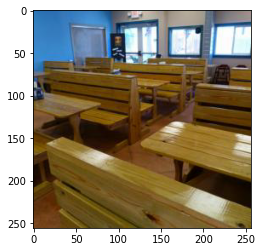

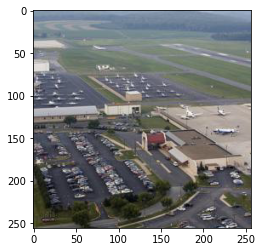

In [22]:
for idx, (X,y) in enumerate(dl_trn):
    plt.figure(idx)
    img = torch2np(X[0])
    plt.imshow(denorm(img))

### Dali TFRecord Dataloader

In [23]:
batch_size = 4
num_workers = 4
num_samples = 6

pipeline_trn = TFRecordPipeline(file_tfrecord=dir_content/'formatted_256'/'trn.tfrecord',
                                batch_size=batch_size,
                                num_workers=num_workers)
dl_trn = DaliDataloader(pipeline_trn, num_samples)

In [24]:
%timeit next(iter(dl_trn))

3.38 ms ± 118 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


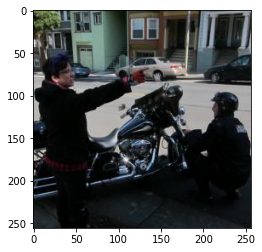

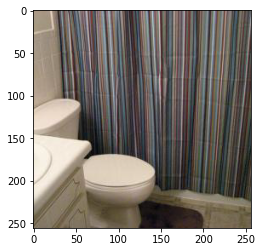

In [25]:
for idx, (X,y) in enumerate(dl_trn):
    plt.figure(idx)
    img = torch2np(X[0])
    plt.imshow(denorm(img))

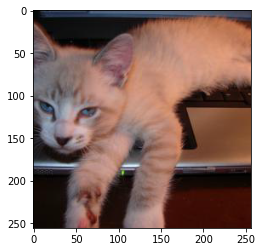

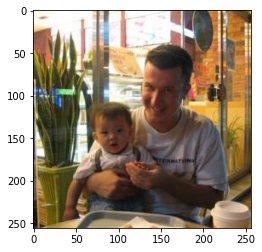

In [26]:
for idx, (X,y) in enumerate(dl_trn):
    plt.figure(idx)
    img = torch2np(X[0])
    plt.imshow(denorm(img))

# Build

In [27]:
!nbdev_build_lib

Converted data.ipynb.
Converted format_images.ipynb.
Converted models.ipynb.
Converted stream.ipynb.
